In [104]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
train = pd.read_csv("train.csv", dtype={"Age": np.float64})
test = pd.read_csv("test.csv", dtype={"Age": np.float64})
train.head()
passengerId = test["PassengerId"]
allData = pd.concat([train, test], ignore_index = True)

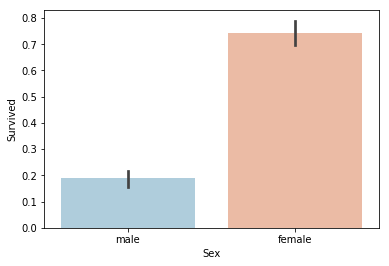

In [105]:
sns.barplot(x = "Sex", y = "Survived", data = train, palette = "RdBu_r")

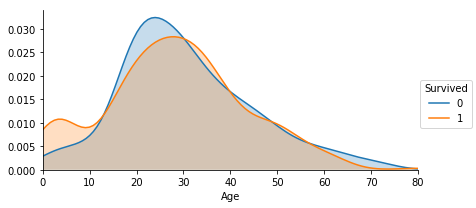

In [106]:
facet = sns.FacetGrid(train, hue="Survived", aspect=2)
facet.map(sns.kdeplot, "Age", shade= True)
facet.set(xlim=(0, train["Age"].max()))
facet.add_legend()

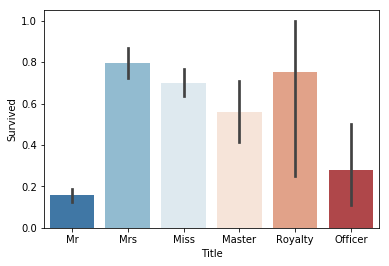

In [107]:
allData["Title"] = allData["Name"].apply(lambda x:x.split(",")[1].split(".")[0].strip())
TitleDict = {}
TitleDict.update(dict.fromkeys(["Capt", "Col", "Major", "Dr", "Rev"], "Officer"))
TitleDict.update(dict.fromkeys(["Don", "Sir", "the Countess", "Dona", "Lady"], "Royalty"))
TitleDict.update(dict.fromkeys(["Mme", "Ms", "Mrs"], "Mrs"))
TitleDict.update(dict.fromkeys(["Mlle", "Miss"], "Miss"))
TitleDict.update(dict.fromkeys(["Mr"], "Mr"))
TitleDict.update(dict.fromkeys(["Master","Jonkheer"], "Master"))
allData["Title"] = allData["Title"].map(TitleDict)
sns.barplot(x="Title", y="Survived", data = allData, palette = "RdBu_r")

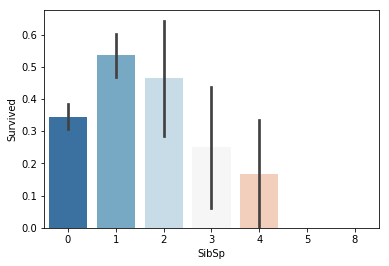

In [108]:
sns.barplot(x = "SibSp", y = "Survived", data = train, palette = "RdBu_r")

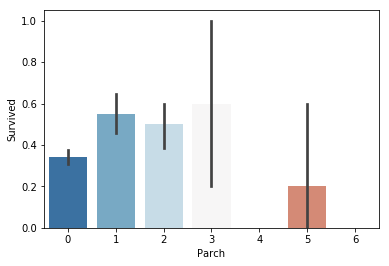

In [109]:
sns.barplot(x = "Parch", y = "Survived", data = train, palette = "RdBu_r")

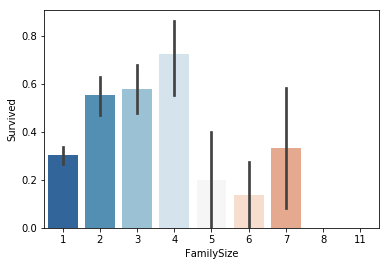

In [110]:
allData["FamilySize"] = allData["SibSp"] + allData["Parch"] + 1
sns.barplot(x = "FamilySize", y = "Survived", data = allData, palette = "RdBu_r")

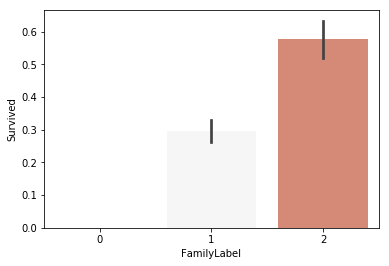

In [111]:
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7): 
        return 0
allData["FamilyLabel"] = allData["FamilySize"].apply(Fam_label)
sns.barplot(x = "FamilyLabel", y="Survived", data = allData, palette = "RdBu_r")

Percentage of Survived 1st Class: 62.96
Percentage of Survived 2nd Class: 47.28
Percentage of Survived 3rd Class: 24.24


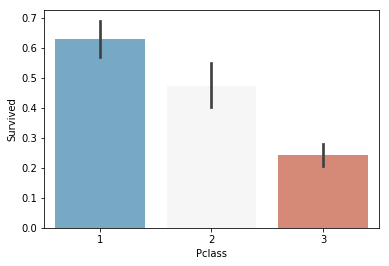

In [112]:
sns.barplot(x = "Pclass", y = "Survived", data = train, palette = "RdBu_r")
print("Percentage of Survived 1st Class: %.2f" % (train["Survived"][train["Pclass"] == 1].value_counts(normalize = 1)[1]*100))
print("Percentage of Survived 2nd Class: %.2f" % (train["Survived"][train["Pclass"] == 2].value_counts(normalize = 1)[1]*100))
print("Percentage of Survived 3rd Class: %.2f" % (train["Survived"][train["Pclass"] == 3].value_counts(normalize = 1)[1]*100))

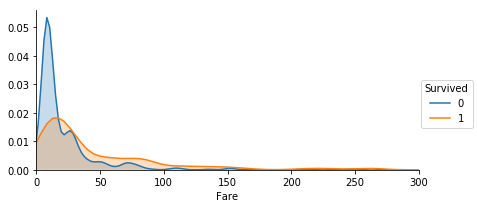

In [113]:
facet = sns.FacetGrid(train, hue="Survived", aspect=2)
facet.map(sns.kdeplot, "Fare", shade= 1)
facet.set(xlim=(0, 300))
facet.add_legend()

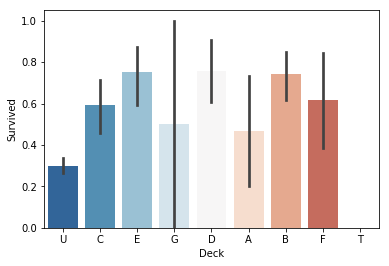

In [114]:
allData["Cabin"] = allData["Cabin"].fillna("Unknown")
allData["Deck"] = allData["Cabin"].str.get(0)
sns.barplot(x = "Deck", y = "Survived", data = allData, palette = "RdBu_r")

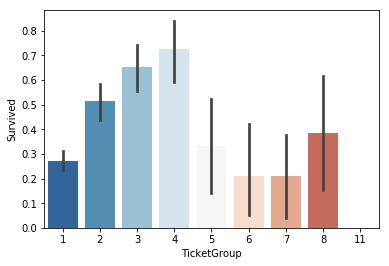

In [115]:
TicketCount = dict(allData["Ticket"].value_counts())
allData["TicketGroup"] = allData["Ticket"].apply(lambda x:TicketCount[x])
sns.barplot(x = "TicketGroup", y = "Survived", data = allData, palette = "RdBu_r")

In [116]:
ageDefine = allData[["Age", "Pclass", "Sex", "Title"]]
ageDefine = pd.get_dummies(ageDefine)
knownAge = ageDefine[ageDefine.Age.notnull()].as_matrix()
unknowAge = ageDefine[ageDefine.Age.isnull()].as_matrix()
X = knownAge[:, 1:]
y = knownAge[:, 0]
rfr = RandomForestRegressor(random_state = 0, n_estimators = 100, n_jobs = -1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknowAge[:,1::])
allData.loc[(allData.Age.isnull()), "Age"] = predictedAges

In [117]:
allData[allData["Embarked"].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,1,1,B,2
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,1,1,B,2


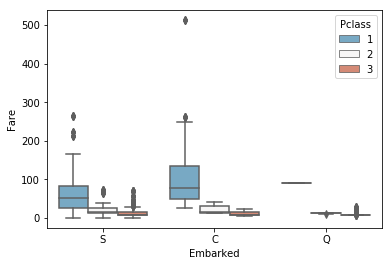

In [118]:
sns.boxplot(x = "Embarked", y = "Fare", hue = "Pclass", data = allData, palette = "RdBu_r")

In [119]:
allData["Embarked"] = allData["Embarked"].fillna("C")

In [120]:
allData[allData["Fare"].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,1,1,U,1


In [121]:
fare = allData[(allData["Embarked"] == "S") & (allData["Pclass"] ==3)].Fare.median()
allData["Fare"] = allData["Fare"].fillna(fare)

In [122]:
allData["Surname"] = allData["Name"].apply(lambda x:x.split(",")[0].strip())
surnameCount = dict(allData["Surname"].value_counts())
allData["FamilyGroup"] = allData["Surname"].apply(lambda x:surnameCount[x])
femaleChildGroup = allData.loc[(allData["FamilyGroup"]>=2) & ((allData["Age"]<=12) | (allData["Sex"] == "female"))]
maleAdultGroup = allData.loc[(allData["FamilyGroup"]>=2) & (allData["Age"]>12) & (allData["Sex"] == "male")]

In [123]:
femaleChild = pd.DataFrame(femaleChildGroup.groupby("Surname")["Survived"].mean().value_counts())
femaleChild.columns = ["GroupCount"]
femaleChild

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


Text(0.5,0,'Average Survived')

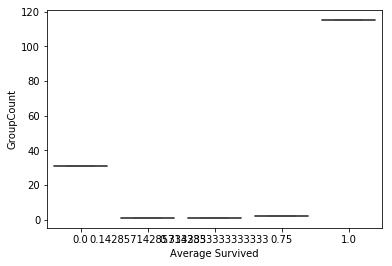

In [124]:
sns.boxplot(x = femaleChild.index, y = femaleChild["GroupCount"], palette = "RdBu_r").set_xlabel("Average Survived")

In [125]:
maleAdult = pd.DataFrame(maleAdultGroup.groupby("Surname")["Survived"].mean().value_counts())
maleAdult.columns = ["GroupCount"]
maleAdult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


Text(0.5,0,'Average Survived')

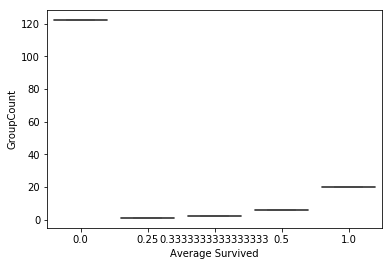

In [126]:
sns.boxplot(x = maleAdult.index, y = maleAdult["GroupCount"], palette = "RdBu_r").set_xlabel("Average Survived")

In [127]:
femaleChildGroup = femaleChildGroup.groupby("Surname")["Survived"].mean()
deadList = set(femaleChildGroup[femaleChildGroup.apply(lambda x:x == 0)].index)
print(deadList)
maleAdultList = maleAdultGroup.groupby("Surname")["Survived"].mean()
survivedList = set(maleAdultList[maleAdultList.apply(lambda x:x == 1)].index)
print(survivedList)

{'Jussila', 'Oreskovic', 'Turpin', 'Cacic', 'Johnston', 'Lahtinen', 'Canavan', 'Sage', 'Boulos', 'Strom', 'Goodwin', 'Vander Planke', 'Lobb', 'Skoog', 'Caram', 'Rice', 'Zabour', 'Danbom', 'Ford', 'Panula', 'Robins', 'Olsson', 'Rosblom', 'Barbara', 'Ilmakangas', 'Lefebre', 'Bourke', 'Arnold-Franchi', 'Attalah', 'Van Impe', 'Palsson'}
{'Beckwith', 'Bishop', 'Frolicher-Stehli', 'Goldenberg', 'McCoy', 'Jussila', 'Kimball', 'Duff Gordon', 'Daly', 'Greenfield', 'Bradley', 'Beane', 'Frauenthal', 'Harder', 'Cardeza', 'Nakid', 'Chambers', 'Jonsson', 'Taylor', 'Dick'}


In [128]:
train = allData.loc[allData["Survived"].notnull()]
test = allData.loc[allData["Survived"].isnull()]
test.loc[(test["Surname"].apply(lambda x:x in deadList)), "Sex"] = "male"
test.loc[(test["Surname"].apply(lambda x:x in deadList)), "Age"] = "60"
test.loc[(test["Surname"].apply(lambda x:x in deadList)), "Title"] = "Mr"
test.loc[(test["Surname"].apply(lambda x:x in survivedList)), "Sex"] = "female"
test.loc[(test["Surname"].apply(lambda x:x in survivedList)), "Age"] = "5"
test.loc[(test["Surname"].apply(lambda x:x in survivedList)), "Title"] = "Miss"

In [129]:
allData = pd.concat([train, test])
allData = allData[["Survived", "Pclass", "Sex", "Age", "Fare", "Embarked", "Title", "FamilyLabel", "Deck", "TicketGroup"]]
allData = pd.get_dummies(allData)
train = allData[allData["Survived"].notnull()]
test = allData[allData["Survived"].isnull()].drop("Survived", axis=1)
X = train.as_matrix()[:,1:]
y = train.as_matrix()[:,0]

In [130]:
pipe = Pipeline([("select", SelectKBest(k=20)), 
                 ("classify", RandomForestClassifier(random_state = 10, max_features = "sqrt"))])
param_test = {"classify__n_estimators": list(range(20, 50, 2)), 
              "classify__max_depth": list(range(3, 60, 3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring = "roc_auc", cv = 10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__max_depth': 6, 'classify__n_estimators': 36} 0.8747589924654688


In [131]:
select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                             n_estimators = 26, 
                             max_depth = 6, 
                             max_features = "sqrt")
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x1a0e1f2268>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0,...estimators=26, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=True))])

In [132]:
cv_score = cross_validation.cross_val_score(pipeline, X, y, cv = 10)
print("CV Score: Mean = %.7g | Std - %.7g" % (np.mean(cv_score), np.std(cv_score)))

CV Score: Mean = 0.8237907 | Std - 0.03511865


In [136]:
predictions = pipeline.predict(test)
submission = pd.DataFrame({"PassengerId": passengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("submission.csv", index=False)